<a href="https://colab.research.google.com/github/nilsozlu/DSA210-Project-NilSozlu/blob/main/Project_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

# grafic settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded.")

Libraries loaded.


In [2]:
def load_and_prep_data(csv_file_list, category_json_path=None):
    """
    Loads, merges, and cleans multiple CSV files specified in the list.
    Performs feature engineering to enrich the dataset.

    Args:
        csv_file_list (list): List of file paths (strings) to CSV files.
        category_json_path (str): Path to the JSON file containing category IDs (optional).

    Returns:
        pd.DataFrame: The processed and merged dataframe.
    """
    print(f"Merging {len(csv_file_list)} files...")

    # 1. Read all files and add to a list
    dataframes = []
    for file_path in csv_file_list:
        try:
            # Try reading with utf-8, with python engine and skipping bad lines
            df_temp = pd.read_csv(file_path, parse_dates=['publishedAt', 'trending_date'], encoding='utf-8', on_bad_lines='skip', engine='python')
        except UnicodeDecodeError:
            # Fallback to latin1 if utf-8 fails, with python engine and skipping bad lines
            df_temp = pd.read_csv(file_path, parse_dates=['publishedAt', 'trending_date'], encoding='latin1', on_bad_lines='skip', engine='python')
        except Exception as e:
            print(f"Warning: Could not read file {file_path} due to error: {e}. Skipping this file.")
            continue # Skip to the next file if an error occurs during reading

        # Optional: Track source file
        df_temp['source_file'] = file_path
        dataframes.append(df_temp)

    if not dataframes:
        print("Error: No dataframes were successfully loaded.")
        return pd.DataFrame()

    # 2. Concatenate all dataframes
    df_main = pd.concat(dataframes, ignore_index=True)

    # Clean column names (remove whitespace)
    df_main.columns = [c.strip() for c in df_main.columns]

    # Data Cleaning: Drop rows with missing critical info
    df_main.dropna(subset=['video_id', 'title'], inplace=True)

    # 3. FEATURE ENGINEERING

    # A) Time-based features
    # Convert 'publishedAt' to datetime and remove timezone info for consistency
    df_main['publishedAt'] = pd.to_datetime(df_main['publishedAt'], format='mixed').dt.tz_localize(None)
    df_main['publish_hour'] = df_main['publishedAt'].dt.hour
    df_main['publish_day'] = df_main['publishedAt'].dt.day_name()
    df_main['publish_month'] = df_main['publishedAt'].dt.month_name()

    # B) Text-based features
    df_main['title_length'] = df_main['title'].apply(lambda x: len(str(x)))
    df_main['tag_count'] = df_main['tags'].apply(lambda x: len(str(x).split('|')) if pd.notnull(x) else 0)

    # C) Engagement features
    # Adding +1 to view_count to avoid division by zero errors
    df_main['like_ratio'] = df_main['likes'] / (df_main['view_count'] + 1)
    df_main['comment_ratio'] = df_main['comment_count'] / (df_main['view_count'] + 1)
    df_main['engagement_score'] = (df_main['likes'] + df_main['comment_count']) / (df_main['view_count'] + 1)

    # D) Trending behavior
    df_main['trending_date'] = pd.to_datetime(df_main['trending_date'], format='mixed').dt.tz_localize(None)
    df_main['days_until_trending'] = (df_main['trending_date'] - df_main['publishedAt']).dt.days

    # Map Category IDs to Names if JSON is provided
    if category_json_path:
        try:
            with open(category_json_path, 'r') as f:
                categories = json.load(f)['items']
            cat_dict = {int(c['id']): c['snippet']['title'] for c in categories}
            df_main['category_name'] = df_main['categoryId'].map(cat_dict)
        except Exception as e:
            print(f"Warning: JSON file could not be processed ({e}). Using ID as category name.")
            df_main['category_name'] = df_main['categoryId'].astype(str)
    else:
        df_main['category_name'] = df_main['categoryId'].astype(str)

    print("Data preparation complete!")
    return df_main

In [3]:
def perform_eda(df):
    """
    Generates exploratory data analysis plots with Log-Scale updates based on feedback.
    """
    print("--- Starting Exploratory Data Analysis ---")

    # 1. Distributions (Log10 Scale) - Professor's Request
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # View Count Histogram (Log Scale)
    sns.histplot(np.log10(df['view_count'] + 1), bins=50, kde=True, ax=ax[0], color='blue')
    ax[0].set_title('Distribution of View Counts (Log10 Scale)')
    ax[0].set_xlabel('Log10(View Count)')
    ax[0].set_ylabel('Frequency')

    # Likes Histogram (Log Scale)
    sns.histplot(np.log10(df['likes'] + 1), bins=50, kde=True, ax=ax[1], color='red')
    ax[1].set_title('Distribution of Likes (Log10 Scale)')
    ax[1].set_xlabel('Log10(Likes)')
    ax[1].set_ylabel('Frequency')
    plt.show()

    # 2. Category Analysis
    plt.figure(figsize=(14, 6))
    order = df['category_name'].value_counts().index
    sns.countplot(y='category_name', data=df, order=order, palette='viridis')
    plt.title('Frequency of Videos by Category')
    plt.xlabel('Number of Videos')
    plt.ylabel('Category Name')
    plt.show()

    # 3. Log-Log Scatter Plot (Power Law Relationship)
    plt.figure(figsize=(10, 8))
    # Sample data to avoid overplotting if dataset is huge
    sns.scatterplot(x='likes', y='view_count', data=df.sample(min(5000, len(df))), alpha=0.5)

    # Log scales for both axes
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Likes vs View Count (Log-Log Scale)')
    plt.xlabel('Likes (Log Scale)')
    plt.ylabel('View Count (Log Scale)')
    plt.show()

    # 4. Correlation Heatmap
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    corr_cols = ['view_count', 'likes', 'comment_count', 'engagement_score',
                 'title_length', 'days_until_trending']
    existing_cols = [c for c in corr_cols if c in numeric_df.columns]

    sns.heatmap(numeric_df[existing_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

In [4]:
def test_hypotheses(df):
    print("\n--- Hipotez Tests ---")

    # ---------------------------------------------------------
    # HT1: Category -> View Count (ANOVA)
    # H0: No average viewing difference between categories.
    # ---------------------------------------------------------
    print("\n[HT1] Category vs View Count (ANOVA)")

    # Preparing the data
    categories = df['category_name'].unique()
    cat_groups = [df[df['category_name'] == cat]['view_count'].values for cat in categories]

    # ANOVA Test
    f_stat, p_val = stats.f_oneway(*cat_groups)
    print(f"F-Statistic: {f_stat:.2f}, P-value: {p_val:.4e}")

    if p_val < 0.05:
        print("H0 rejected. There is a significant difference between the categories.")
    else:
        print("H0 cannot be rejected. There is no significant difference between the categories.")

    # Visualizing (Boxplot)
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='category_name', y='view_count', data=df, showfliers=False)
    plt.xticks(rotation=45)
    plt.title('View Count Distribution by Category (Outliers Hidden)')
    plt.show()

    # ---------------------------------------------------------
    # HT2: Upload Hour -> View Count (ANOVA)
    # H0: Upload hour doesn't affect view count.
    # ---------------------------------------------------------
    print("\n[HT2] Upload Hour vs View Count (ANOVA)")

    # Group the hours: morning, afternoon, evening, night
    def categorize_hour(h):
        if 5 <= h < 12: return 'Morning'
        elif 12 <= h < 17: return 'Afternoon'
        elif 17 <= h < 22: return 'Evening'
        else: return 'Night'

    df['day_part'] = df['publish_hour'].apply(categorize_hour)

    groups = [df[df['day_part'] == p]['view_count'].values for p in df['day_part'].unique()]
    f_stat_h, p_val_h = stats.f_oneway(*groups)
    print(f"F-Statistic: {f_stat_h:.2f}, P-value: {p_val_h:.4e}")

    # Visualizing
    plt.figure(figsize=(8, 5))
    sns.barplot(x='day_part', y='view_count', data=df, estimator=np.mean, errorbar=('ci', 95))
    plt.title('Average View Count by Time of Day')
    plt.show()

    # ---------------------------------------------------------
    # HT3: Likes vs Views (Correlation)
    # H0:  No correlation between Like and View .
    # ---------------------------------------------------------
    print("\n[HT3] Likes vs Views (Pearson Correlation)")

    corr_coef, p_val_c = stats.pearsonr(df['likes'], df['view_count'])
    print(f"Pearson Correlation: {corr_coef:.2f}, P-value: {p_val_c:.4e}")

    if p_val_c < 0.05:
        print("CONCLUSION: There is a significant positive relationship.")

    # Visualizing (Scatter + Regression)
    plt.figure(figsize=(8, 6))
    sns.regplot(x='likes', y='view_count', data=df.sample(5000), scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Likes vs Views Correlation (Sampled Data)')
    plt.show()

In [5]:
# --- MACHINE LEARNING FUNCTION ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def train_ml_models(df):
    """
    Trains ML models on a sampled dataset to ensure fast execution.
    """
    print("\n--- Starting Machine Learning Analysis ---")

    # 1. Prepare Data
    features = ['likes', 'comment_count', 'title_length', 'tag_count', 'publish_hour']

    # Combine features with target
    df_ml = df[features + ['category_name', 'view_count']].copy()

    # Convert categories to numbers
    df_ml = pd.get_dummies(df_ml, columns=['category_name'], drop_first=True)
    df_ml.dropna(inplace=True)

    # --- OPTIMIZATION STEP: SAMPLING ---
    # If dataset is huge, take a random sample of 20,000 rows to speed up training.
    if len(df_ml) > 20000:
        print(f"Dataset is large ({len(df_ml)} rows). Sampling 20,000 rows for faster training...")
        df_ml = df_ml.sample(n=20000, random_state=42)

    # Split X and y
    X = df_ml.drop('view_count', axis=1)
    y = df_ml['view_count']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training Data Size: {X_train.shape[0]} samples")

    # 2. Linear Regression
    print("\n[Model 1] Training Linear Regression...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print(f"Linear Regression R² Score: {r2_score(y_test, y_pred_lr):.4f}")

    # 3. Random Forest (Optimized parameters)
    print("\n[Model 2] Training Random Forest...")
    # n_jobs=-1 uses all CPU cores, max_depth=10 limits complexity for speed
    rf = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print(f"Random Forest R² Score: {r2_score(y_test, y_pred_rf):.4f}")

    # 4. Feature Importance Plot
    if hasattr(rf, 'feature_importances_'):
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1][:10]

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances (Random Forest)")
        plt.bar(range(len(indices)), importances[indices], align="center", color='teal')
        plt.xticks(range(len(indices)), X.columns[indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    print("\nML Analysis Complete.")

In [6]:
files_to_load = [
    '/content/BR_youtube_trending_data.csv',
    '/content/CA_youtube_trending_data.csv',
    '/content/DE_youtube_trending_data.csv',
    '/content/FR_youtube_trending_data.csv',
    '/content/JP_youtube_trending_data.csv',
    '/content/US_youtube_trending_data.csv',
    '/content/GB_youtube_trending_data.csv'
]

# Load and process the data
df = load_and_prep_data(files_to_load)

# Display first few rows
df.head()

Merging 7 files...
Data preparation complete!


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,publish_hour,publish_day,publish_month,title_length,tag_count,like_ratio,comment_ratio,engagement_score,days_until_trending,category_name
0,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11 22:21:49,UCGfBwrCoi9ZJjKiUK8MmJNw,Pietro Guedes,22,2020-08-12,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,...,22,Tuesday,August,46,14,0.322530,0.017056,0.339586,0,22
1,jbGRowa5tIk,ITZY “Not Shy” M/V TEASER,2020-08-11 15:00:13,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12,JYP Entertainment|JYP|ITZY|있지|ITZY Video|ITZY ...,6000070,714310,...,15,Tuesday,August,25,47,0.119050,0.005173,0.124224,0,10
2,3EfkCrXKZNs,Oh Juliana PARÓDIA - MC Niack,2020-08-10 14:59:00,UCoXZmVma073v5G1cW82UKkA,As Irmãs Mota,22,2020-08-12,OH JULIANA PARÓDIA|MC Niack PARÓDIA|PARÓDIAS|A...,2296748,39761,...,14,Monday,August,29,7,0.017312,0.000000,0.017312,1,22
3,gBjox7vn3-g,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11 15:00:09,UC6Xqz2pm50gDCORYztqhDpg,League of Legends BR,20,2020-08-12,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,...,15,Tuesday,August,48,42,0.153811,0.009144,0.162956,0,20
4,npoUGx7UW7o,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11 20:04:02,UCEWOoncsrmirqnFqxer9lmA,The Noite com Danilo Gentili,23,2020-08-12,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,...,20,Tuesday,August,52,22,0.067410,0.008407,0.075817,0,23


--- Starting Exploratory Data Analysis ---


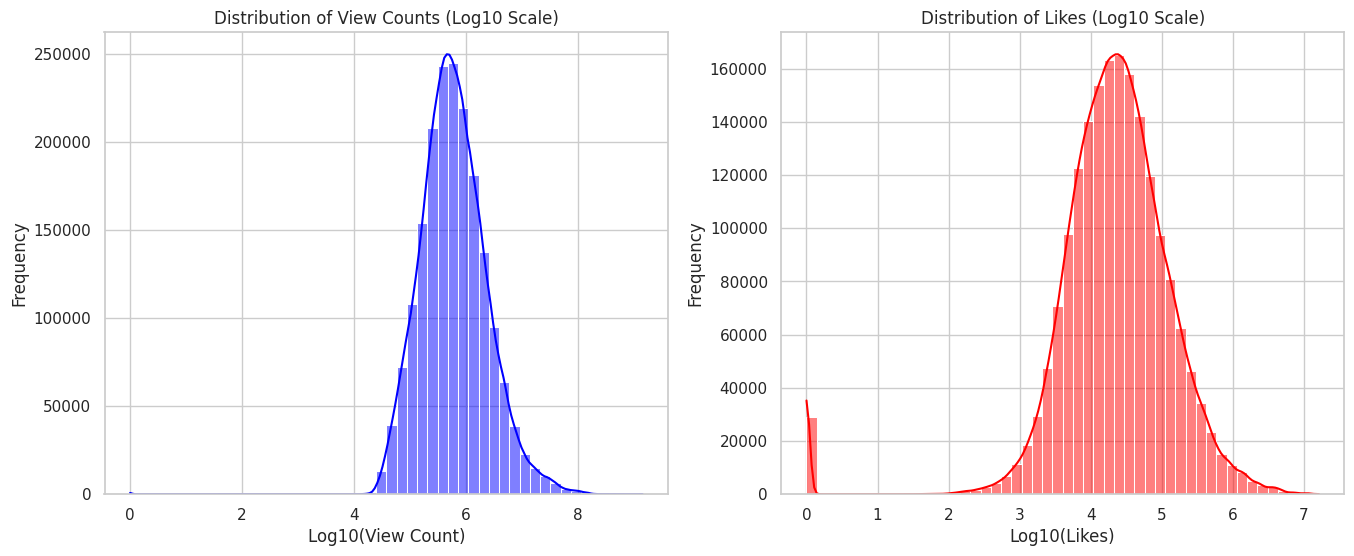

/tmp/ipython-input-3776120268.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category_name', data=df, order=order, palette='viridis')


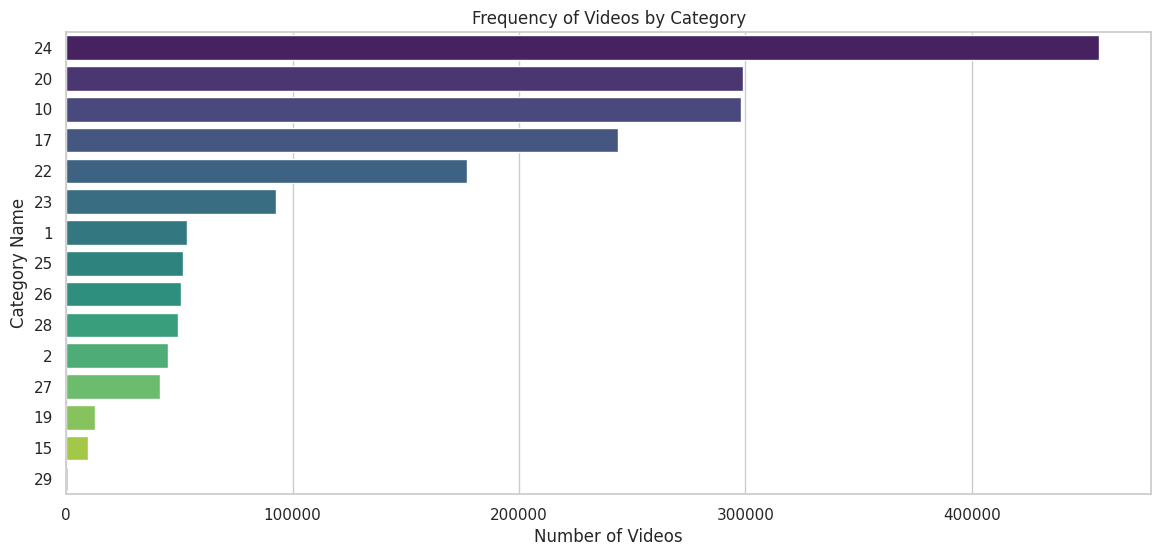

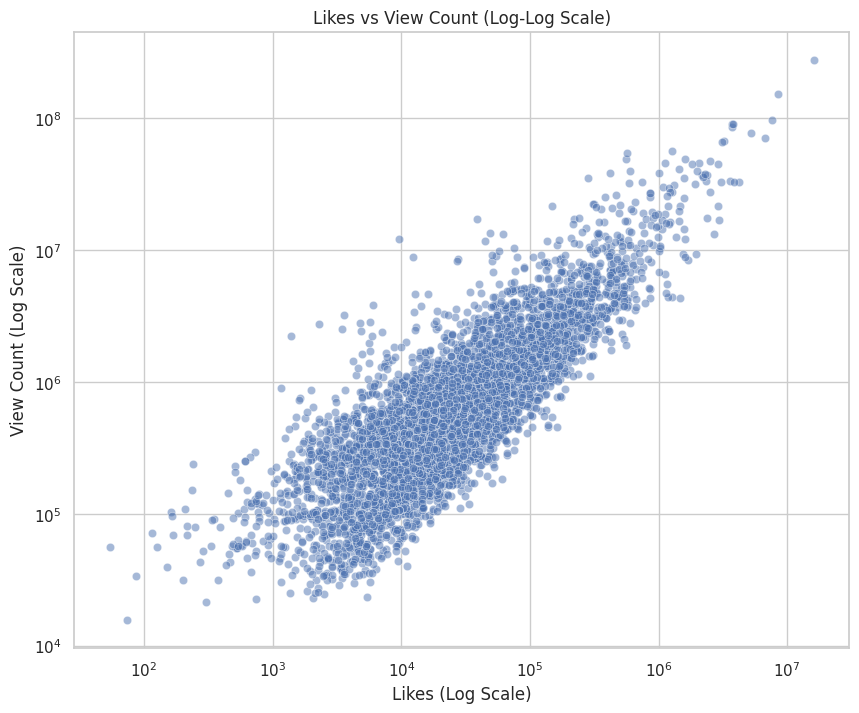

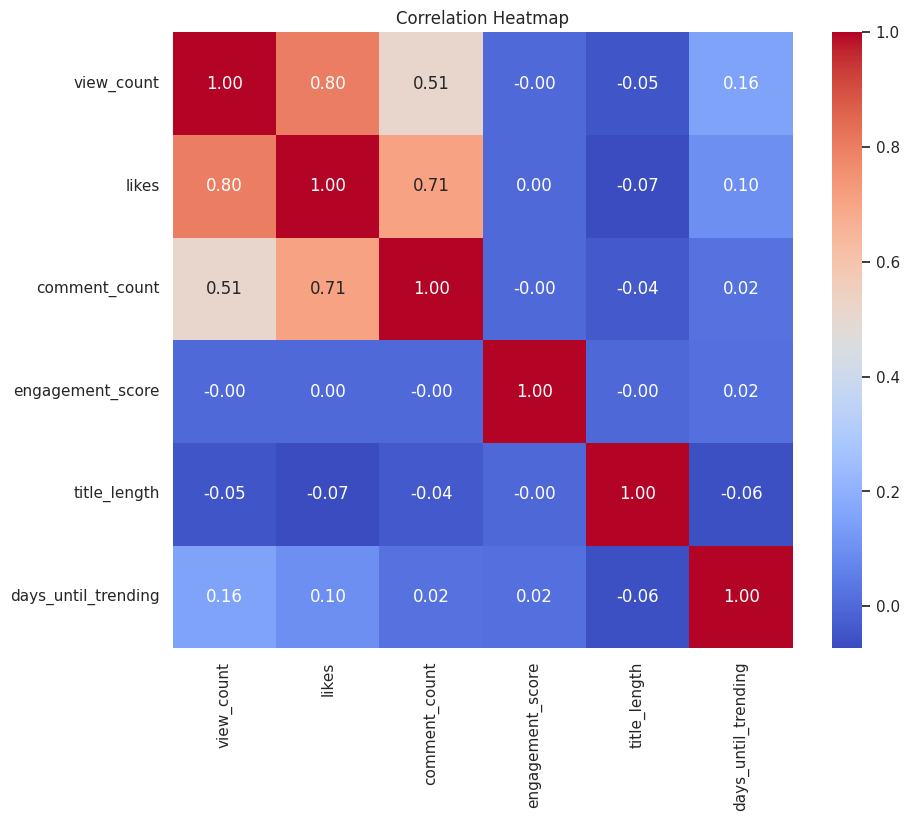

In [7]:
# Start the EDA Analysis
perform_eda(df)


--- Hipotez Tests ---

[HT1] Category vs View Count (ANOVA)
F-Statistic: 2268.78, P-value: 0.0000e+00
H0 rejected. There is a significant difference between the categories.


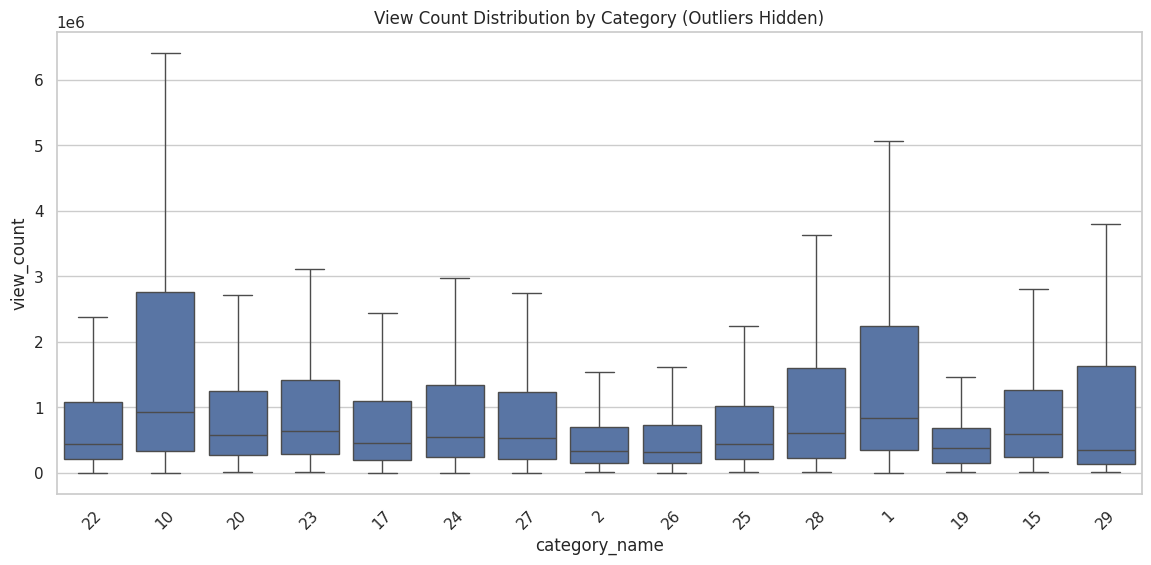


[HT2] Upload Hour vs View Count (ANOVA)
F-Statistic: 1463.96, P-value: 0.0000e+00


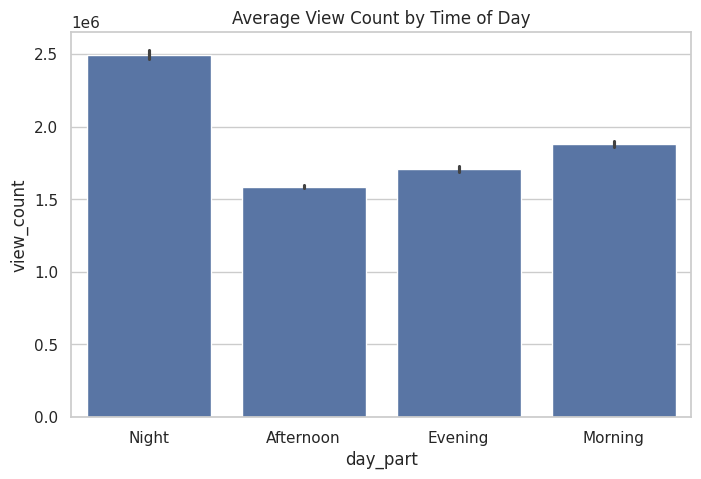


[HT3] Likes vs Views (Pearson Correlation)
Pearson Correlation: 0.80, P-value: 0.0000e+00
CONCLUSION: There is a significant positive relationship.


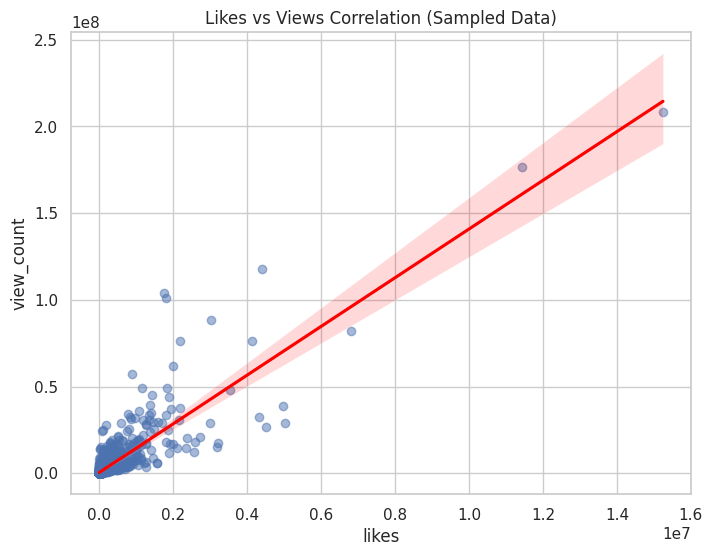

In [8]:
# Start the Hypothesis Tests
test_hypotheses(df)


--- Starting Machine Learning Analysis ---
Dataset is large (1881412 rows). Sampling 20,000 rows for faster training...
Training Data Size: 16000 samples

[Model 1] Training Linear Regression...
Linear Regression R² Score: 0.7953

[Model 2] Training Random Forest...
Random Forest R² Score: 0.8387


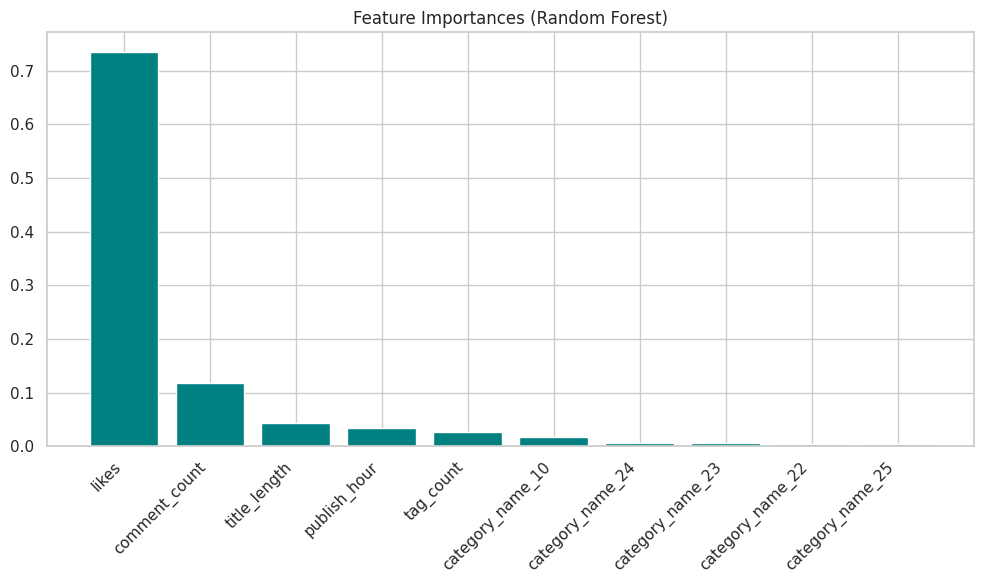


ML Analysis Complete.


In [9]:
train_ml_models(df)